In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 397, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 529, i

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cassava-leaf-disease-classification
!mkdir train
! unzip /content/cassava-leaf-disease-classification.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/train_images/3954399974.jpg  
  inflating: train/train_images/3954487465.jpg  
  inflating: train/train_images/3954910918.jpg  
  inflating: train/train_images/3955391972.jpg  
  inflating: train/train_images/3955442838.jpg  
  inflating: train/train_images/3955739563.jpg  
  inflating: train/train_images/3955931830.jpg  
  inflating: train/train_images/3955972139.jpg  
  inflating: train/train_images/3956075690.jpg  
  inflating: train/train_images/3956077728.jpg  
  inflating: train/train_images/3956155774.jpg  
  inflating: train/train_images/3956271103.jpg  
  inflating: train/train_images/3956372146.jpg  
  inflating: train/train_images/3956407201.jpg  
  inflating: train/train_images/3956550570.jpg  
  inflating: train/train_images/3956605397.jpg  
  inflating: train/train_images/3956778160.jpg  
  inflating: train/train_images/3957562076.jpg  
  inflating: train/train_images/3957612771.jpg  
  inflating: train

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 30.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 1.13.1+cu116
Albumentations version 1.2.1


In [ ]:
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
FOLD_NUM = 3 # For cross-validation
EPOCHS = 5 # Training cycle
RUN_INFERENCE = False

# Directory setting
DATA_DIR = '/content/train/'
MODEL_DIR = '/content/working/'
CSV_SAVE_DIR = '/content/working/'
IMG_SAVE_DIR = '/content/working/' 

# PyTorch variables
SEED = 42
NUM_CLASSES = 5 # df.nunique()['label']
NUM_WORKERS = 2
BATCH_SIZE = 8

LR = 0.0001

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")    

    
def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/
    
    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """    
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result


def show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='classification_validation_score.png'):
    fig = plt.figure(figsize=(15,15))
    for i in range(FOLD_NUM):
        train_acc = train_acc_list[i]
        train_loss = train_loss_list[i]
        valid_acc = valid_acc_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_acc, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_acc, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.legend()

        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM))*2, math.ceil(np.sqrt(FOLD_NUM))*2, (i*2)+2, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

In [ ]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
if RUN_EDA:
    print(df['label'].value_counts())
else:
    print('RUN_EDA is False')

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


3240028167.jpg, label: 3
992352996.jpg, label: 1
3676581137.jpg, label: 3
225631259.jpg, label: 3
1022850256.jpg, label: 3
2653660748.jpg, label: 3


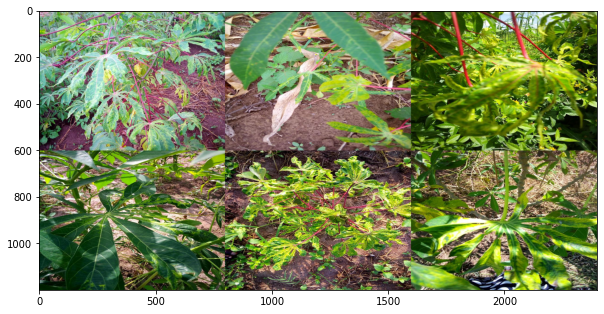

In [ ]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train_images/').glob('*.jpg')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(f'{img_name.name}, label: {df[df["image_id"]==img_name.name]["label"].to_numpy()[0]}')
        if i == 5: 
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

In [ ]:
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train_images/').glob('*')
    pbar = tqdm(img_names, total=len(df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')
else:
    print('RUN_EDA is False')

  0%|          | 0/21397 [00:00<?, ?it/s]

Image shapes are {(600, 800, 3)}.
Image extensions are {'.jpg'}.


In [ ]:
# Image Augmentation
def transform_train():
    transform = [
        A.Resize(512,512,p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.CoarseDropout(p=0.5),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)


# Validation (and test) images should only be resized.
def transform_valid():
    transform = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1.0)
    ]
    return A.Compose(transform)

In [ ]:
# Dataset
class PlantDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, give_label=True):
        """Performed only once when the Dataset object is instantiated.
        give_label should be False for test data
        """ 
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        self.transforms = transforms
        self.give_label = give_label
        
        if give_label == True:
            self.labels = self.df['label'].values

    def __len__(self):
        """Function to return the number of records in the dataset
        """ 
        return self.df.shape[0]
    
    def __getitem__(self, index):
        """Function to return samples corresponding to a given index from a dataset
        """ 
        # get labels
        if self.give_label:
            target = self.labels[index]

        # Load images
        img  = load_img(f'{self.data_root}/{self.df.loc[index]["image_id"]}').astype(np.float32)
        # img /= 255.0 # Normalization

        # Transform images
        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.give_label == True:
            return img, target
        else:
            return img

In [ ]:
# DataLoader
def create_dataloader(df, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = PlantDataset(train_, DATA_DIR+'train_images/', transforms=transform_train())
    valid_datasets = PlantDataset(valid_, DATA_DIR+'train_images/', transforms=transform_valid())

    # Data Loader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

In [ ]:
class EfficientNet_V2(nn.Module):
    def __init__(self, n_out):
        super(EfficientNet_V2, self).__init__()
        # Define model
        self.effnet = timm.create_model('efficientnetv2_s', pretrained=True, num_classes=n_out)

    def forward(self, x):
        return self.effnet(x)

In [ ]:
if RUN_TRAINING and (TRAIN_ALL == False):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')
    
    # Cross-validation
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(df.shape[0]), df['label'].to_numpy())

    # For Visualization
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []


    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'==========Cross Validation Fold {fold+1}==========')
        # Load Data
        train_loader, valid_loader = create_dataloader(df, trn_idx, val_idx)

        # Load model, loss function, and optimizing algorithm
        model = EfficientNet_V2(NUM_CLASSES).to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR)
                
        # For Visualization
        train_accs = []
        valid_accs = []
        train_losses = []
        valid_losses = []

        # Start training
        best_acc = 0
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            
            epoch_loss = 0
            epoch_accuracy = 0
        
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (img, label) in pbar:
                img = img.to(device).float()
                label = label.to(device).long()

                output = model(img)
                loss = loss_fn(output, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                acc = (output.argmax(dim=1) == label).float().mean()
                epoch_accuracy += acc / len(train_loader)
                epoch_loss += loss / len(train_loader)

            print(f'==========Epoch {epoch+1} Start Validation==========')
            with torch.no_grad():
                epoch_val_accuracy = 0
                epoch_val_loss = 0
                val_labels = []
                val_preds = []

                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (img, label) in pbar:
                    img = img.to(device).float()
                    label = label.to(device).long()

                    val_output = model(img)
                    val_loss = loss_fn(val_output, label)

                    acc = (val_output.argmax(dim=1) == label).float().mean()
                    epoch_val_accuracy += acc / len(valid_loader)
                    epoch_val_loss += val_loss / len(valid_loader)

                    val_labels += [label.detach().cpu().numpy()]
                    val_preds += [torch.argmax(val_output, 1).detach().cpu().numpy()]
                
                val_labels = np.concatenate(val_labels)
                val_preds = np.concatenate(val_preds)
            
            # print result from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_accs.append(epoch_accuracy.cpu().numpy())
            valid_accs.append(epoch_val_accuracy.cpu().numpy())
            train_losses.append(epoch_loss.detach().cpu().numpy())
            valid_losses.append(epoch_val_loss.detach().cpu().numpy())
        
        train_acc_list.append(train_accs)
        valid_acc_list.append(valid_accs)
        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, train_accs, valid_accs, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()

    show_validation_score(train_acc_list, train_loss_list, valid_acc_list, valid_loss_list)

else:
    print('Cross validation is not performed')

Using cuda device
==========Cross Validation Fold 1==========


==========Epoch 1 Start Training==========


  0%|          | 0/1783 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1858 - acc: 0.5969 - val_loss : 1.0804 - val_acc: 0.6151 / Exec time 17 min

==========Epoch 2 Start Training==========


  0%|          | 0/1783 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.0817 - acc: 0.6227 - val_loss : 1.0887 - val_acc: 0.6075 / Exec time 17 min

==========Epoch 3 Start Training==========


  0%|          | 0/1783 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.0086 - acc: 0.6392 - val_loss : 0.9504 - val_acc: 0.6532 / Exec time 17 min

==========Epoch 4 Start Training==========


  0%|          | 0/1783 [00:00<?, ?it/s]

==========Epoch 4 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9389 - acc: 0.6570 - val_loss : 0.9304 - val_acc: 0.6445 / Exec time 17 min

==========Epoch 5 Start Training==========


  0%|          | 0/1783 [00:00<?, ?it/s]

==========Epoch 5 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8713 - acc: 0.6699 - val_loss : 0.8453 - val_acc: 0.6914 / Exec time 17 min

==========Cross Validation Fold 2==========


==========Epoch 1 Start Training==========


  0%|          | 0/1784 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1737 - acc: 0.5990 - val_loss : 1.0865 - val_acc: 0.6159 / Exec time 17 min

==========Epoch 2 Start Training==========


  0%|          | 0/1784 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/892 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.0679 - acc: 0.6237 - val_loss : 1.0391 - val_acc: 0.6191 / Exec time 17 min

==========Epoch 3 Start Training==========


  0%|          | 0/1784 [00:00<?, ?it/s]